## 時系列データとして見てみる

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ginza
import spacy
%matplotlib inline

In [2]:
def removeZenkakuSpace(df, cols):
    for col in cols:
        df[col] = df[col].str.replace('　', ' ')
    return df

def histEachFavs(df, col, height=3, aspect=4, title=''):
    for fav in sorted(df[FAV].unique()):
        sns.catplot(x=col,data=df.query(f"{FAV} == @fav"),kind='count',height=height, aspect=aspect)
        plt.title(f'{title} fav group:{fav}')
        
def getQueries(df, cols):
    assert type(cols) == str or type(cols) == list, 'cols is str or list'
    queries = []
    if type(cols) == str:
        queries = [f'{cols} == {flag}' for flag in sorted(df[cols].unique())]
    elif type(cols) == list:
        for col in cols:
            col_queries = [f'{col} == {flag}' for flag in sorted(df[col].unique())]
            if len(queries) == 0:
                queries = col_queries
            else:
                queries = [f"{q} & {col_queries[0]}" for q in queries] + [f'{q} & {col_queries[1]}' for q in queries]
            
    return queries

def columnUnique(df, col):
    return sorted(df[col].unique())

def histColumnsFavs(df, cols:list, height=3, aspect=6, title=''):
    queries = getQueries(df, cols)
    for query in queries:
        data = df.query(query)
        if len(data) == 0:
            continue
        sns.catplot(x=FAV,data=data,kind='count',height=height, aspect=aspect)
        plt.title(f'{title} {query}')
        
def histEachFavsByCategory(df, df_target, col):
    cats = sorted(df[col].unique())
    for cat in cats:
        fig, axes = plt.subplots(figsize=(30,10), ncols=3, nrows=2)
        for ax, fav in zip(axes.ravel(), favs):
            target_mask = (df[FAV] == fav) & (df[col] == cat)
            ax.hist(df_target.loc[target_mask], bins=100)
            ax.set_xlim(-1,df_target.max())
            ax.set_title(f'bgenre:{cat}, fav:{fav}, num={target_mask.sum()}')

In [47]:
out_dir = '../output'
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')
ID = 'ncode'
FAV = 'fav_novel_cnt_bin'
favs = sorted(train_df[FAV].unique())

train_df.userid = train_df.userid.astype('str')
train_df.genre = train_df.genre.astype('str')
test_df.userid = test_df.userid.astype('str')
test_df.genre = test_df.genre.astype('str')
str_cols = ['title', 'story', 'keyword', 'writer']
for df in [train_df, test_df]:
    removeZenkakuSpace(df, str_cols)

In [48]:
train_df.columns

Index(['ncode', 'general_firstup', 'title', 'story', 'keyword', 'userid',
       'writer', 'biggenre', 'genre', 'novel_type', 'end', 'isstop', 'isr15',
       'isbl', 'isgl', 'iszankoku', 'istensei', 'istenni', 'pc_or_k',
       'fav_novel_cnt_bin'],
      dtype='object')

In [49]:
train_df.general_firstup.values[0]

'2007-04-01 16:40:57'

In [52]:
'-'.join(train_df.general_firstup.values[0].split('-')[0:2])

'2007-04'

In [76]:
test_df['up_month'] = np.vectorize(lambda x: '-'.join(x.split('-')[0:2]))(test_df.general_firstup)
test_df['up_day'] = np.vectorize(lambda x: x.split(' ')[0])(test_df.general_firstup)

In [56]:
train_df.up_day

0        2007-04-01
1        2007-04-22
2        2007-08-22
3        2007-09-06
4        2007-09-17
            ...    
39995    2021-08-12
39996    2021-08-12
39997    2021-08-12
39998    2021-08-12
39999    2021-08-12
Name: up_day, Length: 40000, dtype: object

In [21]:
train_df.general_firstup

0        2007-04-01
1        2007-04-22
2        2007-08-22
3        2007-09-06
4        2007-09-17
            ...    
39995    2021-08-12
39996    2021-08-12
39997    2021-08-12
39998    2021-08-12
39999    2021-08-12
Name: general_firstup, Length: 40000, dtype: object

In [39]:
mask = (train_df.groupby('general_firstup')[FAV].count() < 3)

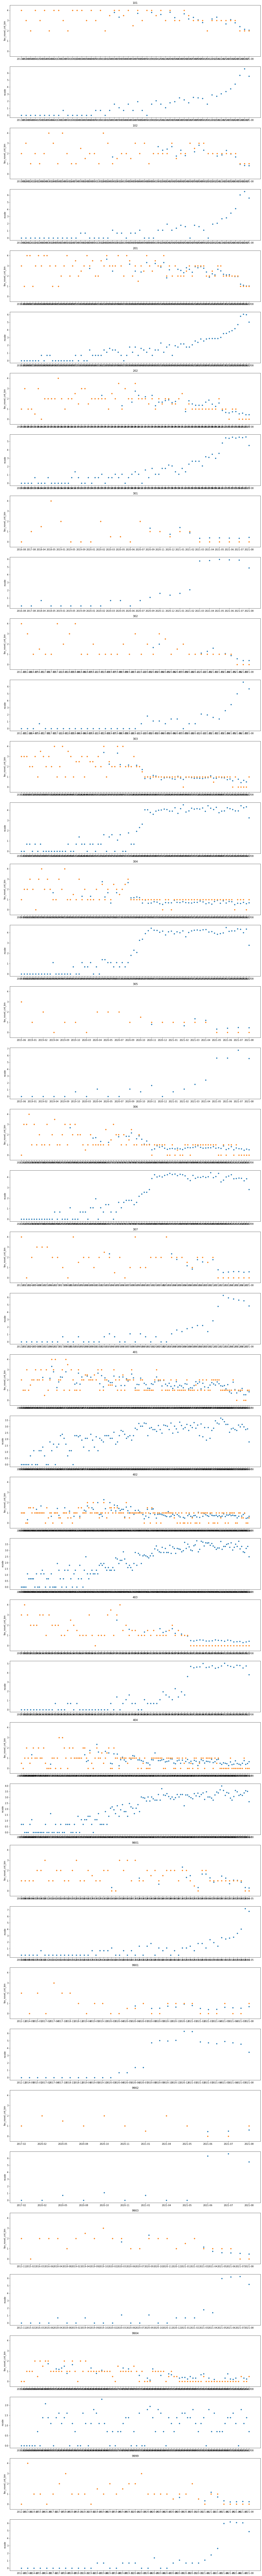

In [97]:
rows = len(train_df.genre.unique())
fig, axes = plt.subplots(figsize=(20,10*rows), ncols=1, nrows=2*rows)
col = 'up_month'
target = 'genre'
for idx, genre in enumerate(columnUnique(train_df, target)):
    x=train_df.query(f'{target} == @genre')[col].unique()
    sns.scatterplot(x=x, y=train_df.query(f'{target} == @genre').groupby(col)[FAV].mean(), ax=axes[2*idx],legend='auto')
    sns.scatterplot(x=x, y=train_df.query(f'{target} == @genre').groupby(col)[FAV].median(), ax=axes[2*idx], legend='auto')
    axes[2*idx].set_title(genre)
    axes[2*idx].set_ylim(-0.5,4.5)
    sns.scatterplot(x=x, y=np.log(train_df.query(f'{target} == @genre').groupby(col)[ID].count()), ax=axes[2*idx+1])

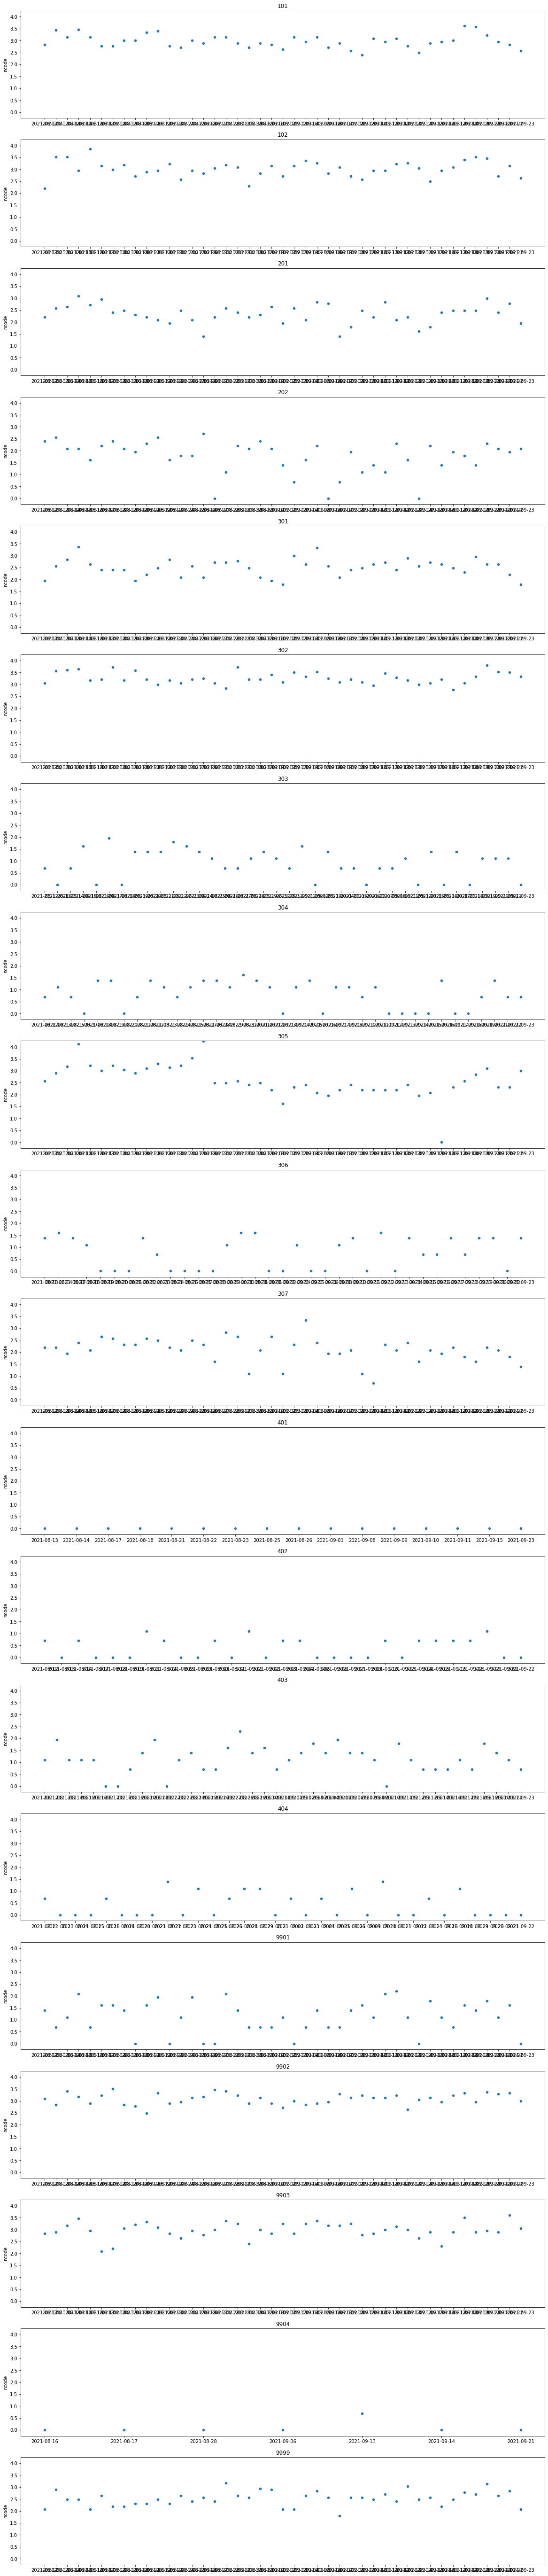

In [103]:
rows = len(test_df.genre.unique())
fig, axes = plt.subplots(figsize=(20,5*rows), ncols=1, nrows=rows)
col = 'up_day'
target = 'genre'
for idx, genre in enumerate(columnUnique(test_df, target)):
    x=test_df.query(f'{target} == @genre')[col].unique()
    sns.scatterplot(x=x, y=np.log(test_df.query(f'genre == @genre').groupby(col)[ID].count()), ax=axes[idx])
    axes[idx].set_title(genre)
    axes[idx].set_ylim(-0.25, 4.25)

In [65]:
axes[0]

<AxesSubplot:>

/home/wsato/work/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='fav_novel_cnt_bin'>

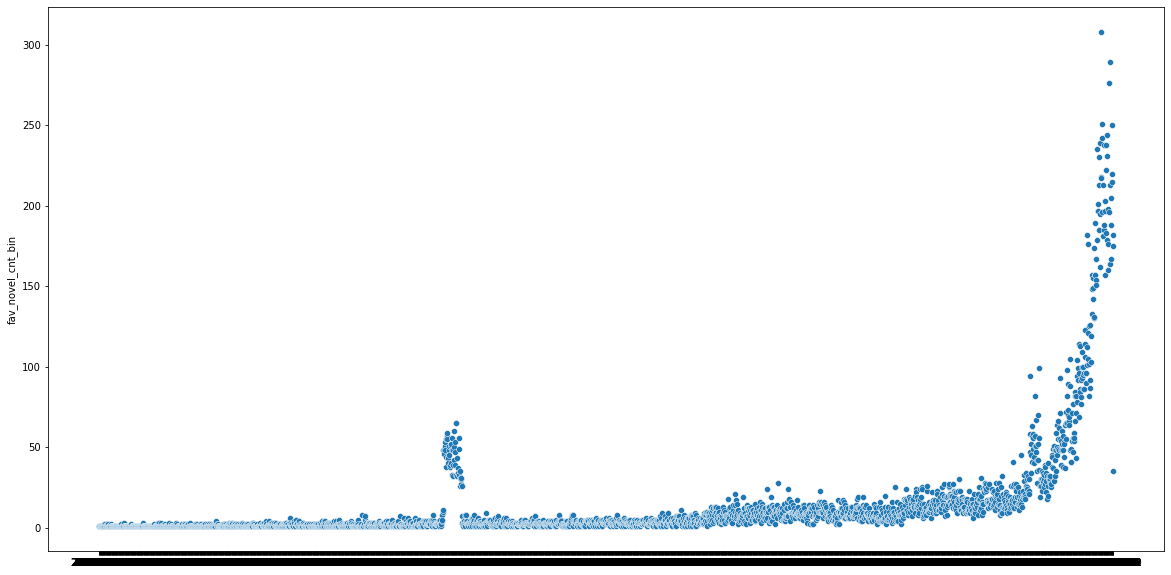

In [44]:
fig = plt.figure(figsize=(20,10))

In [46]:
train_df.groupby('general_firstup')[FAV].count() > 50

general_firstup
2007-04-01    False
2007-04-22    False
2007-08-22    False
2007-09-06    False
2007-09-17    False
              ...  
2021-08-08     True
2021-08-09     True
2021-08-10     True
2021-08-11     True
2021-08-12    False
Name: fav_novel_cnt_bin, Length: 2883, dtype: bool